In [1]:
import numpy as np
import os
import mne
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy
from itertools import product
from numpy import linalg as LA
from scipy.linalg import block_diag
from cca_zoo.linear import MCCA, rCCA
from algo_suppl import CorrCA_LW, MCCA_LW
%matplotlib widget

In [2]:
def process_data_per_view(view, L, offset, NORMALIZE=True):
    view_hankelized = utils.block_Hankel(view, L, offset)
    if NORMALIZE:
        view_hankelized = utils.normalize_per_view(view_hankelized)
    return view_hankelized

In [3]:
# def change_feats_label(feat_att_unatt_list_ori, pair_ids=[5,6,7]):
#     feat_att_unatt_list = copy.deepcopy(feat_att_unatt_list_ori)
#     video_ids = [[2*i-2, 2*i-1] for i in pair_ids]
#     video_ids = [item for sublist in video_ids for item in sublist]
#     for id in video_ids:
#         temp = feat_att_unatt_list[id][:, 0].copy()
#         feat_att_unatt_list[id][:, 0] = feat_att_unatt_list[id][:, 1]
#         feat_att_unatt_list[id][:, 1] = temp
#     return feat_att_unatt_list

In [4]:
def change_feats_label(views, fs, TRUELABEL_PERCENT, resolu=30, RANDSEED=0):
    np.random.seed(RANDSEED)
    data, feats_att_unatt = views
    feats_segs = utils.into_trials_with_overlap(feats_att_unatt, fs, resolu, overlap=0)
    data_segs = utils.into_trials_with_overlap(data, fs, resolu, overlap=0)
    nb_trials = len(feats_segs)
    nb_false_label = nb_trials - int(nb_trials * TRUELABEL_PERCENT)
    # ceate random index for false label
    idx_false_label = np.random.choice(range(nb_trials), nb_false_label, replace=False)
    # change the label
    for idx in idx_false_label:
        # feats_segs[idx][:,0], feats_segs[idx][:,1] = feats_segs[idx][:,1], feats_segs[idx][:,0] 
        temp =  feats_segs[idx][:, 0].copy()
        feats_segs[idx][:, 0] = feats_segs[idx][:, 1]
        feats_segs[idx][:, 1] = temp
    feats_att_unatt = np.concatenate(tuple(feats_segs), axis=0)
    data = np.concatenate(tuple(data_segs), axis=0)
    return [data, feats_att_unatt]

In [5]:
def prepare_train_val_test_data(Subj_ID, MOD, modal_dict, modal_dict_SO, feat_att_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, fs, TRUELABEL_PERCENT, resolu, RANDSEED):
    # Load data for the specific subject
    data_onesubj_list = [data[:,:,Subj_ID] for data in modal_dict[MOD]]
    data_onesubj_SO_list = [data[:,:,Subj_ID] for data in modal_dict_SO[MOD]]
    # feat_modified_list = change_feats_label(feat_att_unatt_list, pair_ids)
    # Split the SI data into training and validation sets
    train_list_folds, val_list_folds = utils.split_multi_mod_LVO([data_onesubj_list, feat_att_unatt_list], leave_out=2)
    data_train, feats_train = change_feats_label(train_list_folds[0], fs, TRUELABEL_PERCENT, resolu, RANDSEED) 

    data_val, feats_val = val_list_folds[0]
    # Use the SO data for testing
    data_test = np.concatenate(tuple(data_onesubj_SO_list), axis=0)
    feats_test = np.concatenate(tuple(feat_SO_list), axis=0)
    views_train = [process_data_per_view(data_train, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_train, L_feats, offset_feats, NORMALIZE=True)]
    views_val = [process_data_per_view(data_val, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_val, L_feats, offset_feats, NORMALIZE=True)]
    views_test = [process_data_per_view(data_test, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_test, L_feats, offset_feats, NORMALIZE=True)]
    return views_train, views_val, views_test

In [6]:
def cal_corr_sum(corr, range_into_account=3, nb_comp_into_account=2):
    corr_ranked = np.sort(corr[:range_into_account])[::-1]
    corr_sum = np.sum(corr_ranked[:nb_comp_into_account])
    return corr_sum

In [7]:
def train_cca_model(views_train, views_val, LWCOV=False, MULTIVIEW=False, latent_dimensions=5, range_into_account=3, nb_comp_into_account=2):
    if LWCOV:
        best_model = MCCA_LW(latent_dimensions=latent_dimensions)
        best_model.fit(views_train)
        best_corr_val = best_model.average_pairwise_correlations(views_val)
        print(f'Corr: {best_corr_val}')
    else:
        param_grid = {'c': [1e-6]} if MULTIVIEW else {'c': [(a, b) for a, b in product([1e-8, 1e-7, 1e-6, 1e-5], repeat=2) if a > b]}
        best_corr_sum = -np.inf
        for c in param_grid['c']:
            model = MCCA(latent_dimensions=latent_dimensions, pca=False, eps=0, c=c) if MULTIVIEW else rCCA(latent_dimensions=latent_dimensions, pca=False, eps=0, c=c)
            model.fit(views_train)
            corr = model.average_pairwise_correlations(views_val)
            corr_sum = cal_corr_sum(corr, range_into_account=range_into_account, nb_comp_into_account=nb_comp_into_account)
            print(f'c: {c}, corr: {corr}')
            if corr_sum > best_corr_sum:
                best_corr_sum = corr_sum
                best_c = c
                best_model = model
                best_corr_val = corr
        print(f'Best c: {best_c}')
    best_corr_train = best_model.average_pairwise_correlations(views_train)
    return best_model, best_corr_val, best_corr_train

In [8]:
def get_mask_from_influence(views_train, model, fs, track_resolu, L_data, L_feats, idx, ITER, CROSSVIEW=True, coe=1):
    # Convert views into trials with overlap
    views_in_segs = [utils.into_trials_with_overlap(view, fs, track_resolu, overlap=0) for view in views_train]
    nb_views = len(views_in_segs)
    nb_segs = len(views_in_segs[0])
    # Get views in each segment
    segs_views = [[views_in_segs[i][j] for i in range(nb_views)] for j in range(nb_segs)]
    # Get influence of views for each segment
    segs_influence_views = [utils.get_influence_all_views(views, model.weights_, [L_data, L_feats], 'SDP', CROSSVIEW=CROSSVIEW, NORMALIZATION=False) for views in segs_views]
    # Stack the influence of views along axis 2; shape of elements in influence_views: (dim_view, nb_components, nb_segs)
    influence_views = [np.stack([segs_influence_views[j][i] for j in range(nb_segs)], axis=2) for i in range(nb_views)]
    influ_diff = influence_views[1][0, idx, :] - influence_views[1][1, idx, :]
    mask = influ_diff > 0
    nb_detected_seg = np.sum(influ_diff < 0)
    # sort the influence difference from the smallest to the largest
    idx_sort = np.argsort(influ_diff)
    coe = 0.5**(ITER+1) if coe is None else coe
    idx_keep = idx_sort[int(coe*nb_detected_seg):]
    mask[idx_keep] = True
    # Create a mask where the influence of the first component is greater than the second
    # mask = influence_views[1][0, idx, :] > influence_views[1][1, idx, :]
    rt = 1 - nb_detected_seg / len(influ_diff)
    print(f'Ratio of True: {rt}')
    return influence_views, mask, rt, views_in_segs

In [9]:
def update_training_views(mask, views_in_segs, L_feats):
    for i, indicator in enumerate(mask):
        if not indicator:
            feats_seg_i = views_in_segs[1][i]
            temp = np.zeros_like(feats_seg_i)
            temp[:, :L_feats] = feats_seg_i[:, L_feats:2 * L_feats]
            temp[:, L_feats:2 * L_feats] = feats_seg_i[:, :L_feats]
            views_in_segs[1][i] = temp
    data_h_train_updated = np.concatenate(tuple(views_in_segs[0]), axis=0)
    feats_h_train_updated = np.concatenate(tuple(views_in_segs[1]), axis=0)
    views_train_updated = [data_h_train_updated, feats_h_train_updated]
    return views_train_updated

In [10]:
def gcca_preprocess(MOD, modal_dict, modal_dict_SO, L=5, offset=2, LWCOV=False, latent_dimensions=32, range_into_account=7, nb_comp_into_account=3):
    nb_subj = modal_dict[MOD][0].shape[2]
    views_list = [[data[:,:,n] for data in modal_dict[MOD]] for n in range(nb_subj)]
    views_SO_list = [[data[:,:,n] for data in modal_dict_SO[MOD]] for n in range(nb_subj)]
    train_list_folds, val_list_folds = utils.split_multi_mod_LVO(views_list, leave_out=2)
    views_train, views_val = train_list_folds[0], val_list_folds[0]
    views_test = [np.concatenate(tuple(data), axis=0) for data in views_SO_list]
    views_train = [process_data_per_view(view, L, offset, NORMALIZE=True) for view in views_train]
    views_val = [process_data_per_view(view, L, offset, NORMALIZE=True) for view in views_val]
    views_test = [process_data_per_view(view, L, offset, NORMALIZE=True) for view in views_test]
    model, isc_val, isc_train = train_cca_model(views_train, views_val, LWCOV=LWCOV, MULTIVIEW=True, latent_dimensions=latent_dimensions, range_into_account=range_into_account, nb_comp_into_account=nb_comp_into_account)
    print(f'ISC train: {isc_train}, ISC val: {isc_val}')
    views_train_transformed = model.transform(views_train)
    views_val_transformed = model.transform(views_val)
    views_test_transformed = model.transform(views_test)
    return model, views_train_transformed, views_val_transformed, views_test_transformed

In [11]:
def prepare_train_val_test_pseudo_data(MOD, modal_dict, modal_dict_SO, feat_att_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, fs, resolu, TRUELABEL_PERCENT=0.9, RANDSEED=0):
    _, views_train_transformed, views_val_transformed, views_test_transformed = gcca_preprocess(MOD, modal_dict, modal_dict_SO, LWCOV=False)
    pseudo_train = np.mean(np.stack(views_train_transformed, axis=2), axis=2)
    pseudo_val = np.mean(np.stack(views_val_transformed, axis=2), axis=2)
    pseudo_test = np.mean(np.stack(views_test_transformed, axis=2), axis=2)
    train_list_folds, val_list_folds = utils.split_multi_mod_LVO([feat_att_unatt_list], leave_out=2)
    feats_train = train_list_folds[0][0]
    pseudo_train, feats_train = change_feats_label([pseudo_train, feats_train], fs, resolu, TRUELABEL_PERCENT, RANDSEED) 
    feats_val = val_list_folds[0][0]
    feats_test = np.concatenate(tuple(feat_SO_list), axis=0)
    views_train = [process_data_per_view(pseudo_train, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_train, L_feats, offset_feats, NORMALIZE=True)]
    views_val = [process_data_per_view(pseudo_val, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_val, L_feats, offset_feats, NORMALIZE=True)]
    views_test = [process_data_per_view(pseudo_test, L_data, offset_data, NORMALIZE=True), process_data_per_view(feats_test, L_feats, offset_feats, NORMALIZE=True)]
    return views_train, views_val, views_test

In [12]:
def match_mismatch(views, model, fs, trial_len, overlap=0.8):
    data, feats = views
    data_seg = utils.into_trials_with_overlap(data, fs, trial_len, overlap=overlap)
    feats_seg = utils.into_trials_with_overlap(feats, fs, trial_len, overlap=overlap)
    mismatch_seg = utils.into_trials_with_overlap(feats, fs, trial_len, overlap=overlap, PERMUTE=True)
    corr_match = [model.average_pairwise_correlations([d, f]) for d, f in zip(data_seg, feats_seg)]
    corr_mismatch = [model.average_pairwise_correlations([d, f]) for d, f in zip(data_seg, mismatch_seg)]
    acc = utils.eval_compete(np.stack(corr_match, axis=0), np.stack(corr_mismatch, axis=0), TRAIN_WITH_ATT=True)
    return acc

In [13]:
def iterate(views_train_ori, views_val, views_test, fs, track_resolu, mm_resolu, L_data, L_feats, MAX_ITER=10, LWCOV=True, CROSSVIEW=True, coe=1):
    views_train = copy.deepcopy(views_train_ori)
    model_list = []
    influence_list = []
    avg_mag_list = []
    rt_list = []
    corr_sum_list = []
    acc_list = []
    for i in range(MAX_ITER):
        model, corr_val, corr_train = train_cca_model(views_train, views_val, LWCOV)
        model_list.append(model)
        print(f'Corr_sum_train: {cal_corr_sum(corr_train)}')
        print(f'Corr_sum_val: {cal_corr_sum(corr_val)}')
        idx = np.argmax(corr_val)
        influence_views, mask, rt, views_in_segs = get_mask_from_influence(views_train, model, fs, track_resolu, L_data, L_feats, idx, ITER=i, CROSSVIEW=CROSSVIEW, coe=coe)
        influence_list.append(influence_views[1][:,idx,:])
        rt_list.append(rt)
        avg_mag = np.array([np.mean(feat[:,[0, L_feats]], axis=0) for feat in views_in_segs[1]])
        avg_mag_list.append(avg_mag.T)
        model.weights_[1] = model.weights_[1][:L_feats, :]
        corr_test = model.average_pairwise_correlations(views_test)
        corr_sum = cal_corr_sum(corr_test)
        corr_sum_list.append(corr_sum)
        print(f'Corr_sum_test: {corr_sum}')
        acc = match_mismatch(views_test, model, fs, mm_resolu)
        acc_list.append(acc)
        views_train = update_training_views(mask, views_in_segs, L_feats)
    return model_list, influence_list, avg_mag_list, rt_list, corr_sum_list, acc_list


## Load data

In [14]:
# Load the data
modal_dict, feat_all_att_list, feat_all_unatt_list, Subj_Set = utils.prepare_data_multimod()
nb_subj = len(Subj_Set)
modal_dict_SO, feat_all_SO_list, _, _ = utils.prepare_data_multimod(SINGLEOBJ=True)
for key in modal_dict:
    modal_dict[key] = [data[:,:,Subj_Set] for data in modal_dict[key]]
    modal_dict_SO[key] = [data[:,:,Subj_Set] for data in modal_dict_SO[key]]
modal_dict['EEG-EOG'] = utils.further_regress_out_list(modal_dict['EEG'], modal_dict['EOG'], 1, 1, 0, 0)
modal_dict_SO['EEG-EOG'] = utils.further_regress_out_list(modal_dict_SO['EEG'], modal_dict_SO['EOG'], 1, 1, 0, 0)
feat_att_unatt_list =[np.stack([att[:,8], unatt[:,8]], axis=1) for att, unatt in zip(feat_all_att_list, feat_all_unatt_list)]
feat_unatt_att_list = [np.stack([unatt[:,8], att[:,8]], axis=1) for att, unatt in zip(feat_all_att_list, feat_all_unatt_list)]
feat_SO_list = [feats[:,8] for feats in feat_all_SO_list]

In [15]:
fs = 30
GCCA_PREPROCESS = False
LWCOV = False
CROSSVIEW = True
TRUELABEL_PERCENT = 0.5
GCCA_PARAMS_H = (5, 2)
TRAIN_MODE = 'SDP'
L_data = 3 if not GCCA_PREPROCESS else 1
L_feats = int(fs/2) 
offset_data = 1 if not GCCA_PREPROCESS else 0
offset_feats = 0 
params_hankel = [(L_data, offset_data), (L_feats, offset_feats)]
MOD = 'EEG-EOG'
track_resolu = 30
label_resolu = 180
mm_resolu = 30
# pair_ids = []
coe = None
# MAX_ITER = 10 if len(pair_ids) !=0 else 5
MAX_ITER = 6
SEED = 12
table_path = f'tables/{MOD}/'
utils.create_dir(table_path, CLEAR=False)

In [ ]:
if GCCA_PREPROCESS:
    # file_name = f'{table_path}Pseudo_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_labelchanged_{''.join(map(str, pair_ids))}_coe{coe}_nbiter{MAX_ITER}{'_lwcov' if LWCOV else ''}.pkl'
    # print(f'#########Subject: Pseudo#########')
    # views_train, views_val, views_test = prepare_train_val_test_pseudo_data(MOD, modal_dict, modal_dict_SO, feat_att_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, pair_ids)
    # model_list, influence_list, avg_mag_list, rt_list, corr_sum_list, acc_list = iterate(views_train, views_val, views_test, fs, track_resolu, L_data, L_feats, MAX_ITER=MAX_ITER, LWCOV=LWCOV, CROSSVIEW=CROSSVIEW, coe=coe)
    # with open(file_name, 'wb') as f:
    #     # create a dictionary to save the data
    #     res = {'model': model_list, 'influence_list': influence_list, 'avg_mag_list': avg_mag_list, 'rt_list': rt_list, 'corr_sum_list': corr_sum_list, 'acc_list': acc_list}
    #     pickle.dump(res, f)
    pass
else:
    for Subj_ID in range(nb_subj):
        # file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_labelchanged_{''.join(map(str, pair_ids))}_coe{coe}_nbiter{MAX_ITER}{'_lwcov' if LWCOV else ''}.pkl'
        file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_truelabelpct_{TRUELABEL_PERCENT}_labelresolu_{label_resolu}_mmresolu_{mm_resolu}coe{coe}_nbiter{MAX_ITER}_seed{SEED}{'_lwcov' if LWCOV else ''}.pkl'
        print(f'#########Subject: {Subj_ID}#########')
        # views_train, views_val, views_test = prepare_train_val_test_data(Subj_ID, MOD, modal_dict, modal_dict_SO, feat_att_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, pair_ids)
        views_train, views_val, views_test = prepare_train_val_test_data(Subj_ID, MOD, modal_dict, modal_dict_SO, feat_att_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, fs, TRUELABEL_PERCENT, label_resolu, RANDSEED=SEED)
        
        model_list, influence_list, avg_mag_list, rt_list, corr_sum_list, acc_list = iterate(views_train, views_val, views_test, fs, track_resolu, mm_resolu, L_data, L_feats, MAX_ITER=MAX_ITER, LWCOV=LWCOV, CROSSVIEW=CROSSVIEW, coe=coe)
        with open(file_name, 'wb') as f:
            # create a dictionary to save the data
            res = {'model': model_list, 'influence_list': influence_list, 'avg_mag_list': avg_mag_list, 'rt_list': rt_list, 'corr_sum_list': corr_sum_list, 'acc_list': acc_list}
            pickle.dump(res, f)

In [34]:
# track_resolu = 10
# MAX_ITER = 6
label_resolu = 60
mm_resolu = 30
track_resolu = 30
coe = None
MAX_ITER = 6
rt = np.zeros((nb_subj, MAX_ITER))
corr_sum = np.zeros((nb_subj, MAX_ITER))
acc = np.zeros((nb_subj, MAX_ITER))
w_data = np.zeros((nb_subj, 64*L_data, 5))
w_feats = np.zeros((nb_subj, L_feats, 5)) 
for Subj_ID in range(nb_subj):
    file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_truelabelpct_{TRUELABEL_PERCENT}_labelresolu_{label_resolu}_mmresolu_{mm_resolu}coe{coe}_nbiter{MAX_ITER}_seed{SEED}{'_lwcov' if LWCOV else ''}.pkl'
    # file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_labelchanged_{''.join(map(str, pair_ids))}_coe{coe}_nbiter{MAX_ITER}{'_lwcov' if LWCOV else ''}.pkl'
    with open(file_name, 'rb') as f:
        res = pickle.load(f)
        rt[Subj_ID,:] = res['rt_list']
        corr_sum[Subj_ID,:] = res['corr_sum_list']
        acc[Subj_ID,:] = res['acc_list']
        # model_list = res['model']
        # w_data_ensemble = np.mean([model.weights_[0] for model in model_list], axis=0)
        # w_data[Subj_ID,:,:] = w_data_ensemble
        # w_feats_ensemble = np.mean([model.weights_[1] for model in model_list], axis=0)
        # w_feats[Subj_ID,:,:] = w_feats_ensemble

In [35]:
# corr_sum_ensemble = []
# views_train, views_val, _ = prepare_train_val_test_data(0, MOD, modal_dict, modal_dict_SO, feat_att_list, feat_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, TRUELABEL=TRUELABEL)
# model, _, _ = train_cca_model(views_train, views_val, LWCOV)
# for Subj_ID in range(nb_subj):
#     _, _, views_test = prepare_train_val_test_data(Subj_ID, MOD, modal_dict, modal_dict_SO, feat_att_list, feat_unatt_list, feat_SO_list, L_data, offset_data, L_feats, offset_feats, TRUELABEL=TRUELABEL)
#     model.weights_[0] = w_data[Subj_ID,:,:]
#     model.weights_[1] = w_feats[Subj_ID,:,:]
#     corr_test = model.average_pairwise_correlations(views_test)
#     corr_sum_ensemble.append(cal_corr_sum(corr_test))

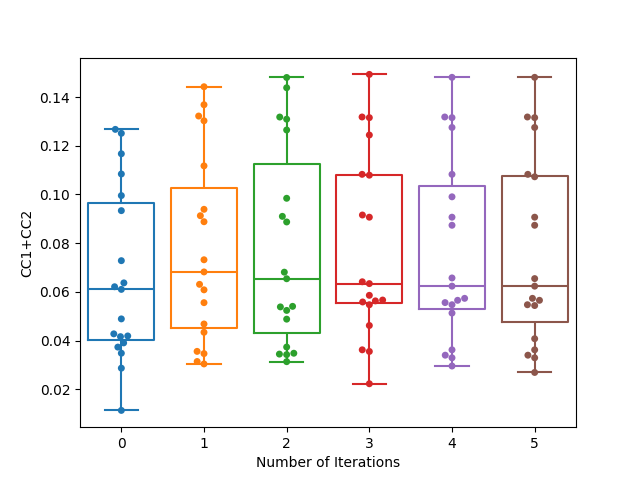

In [36]:
# plot the results as box plots, where the x-axis is the number of iterations
plt.figure()
sns.boxplot(data=corr_sum, fill=None)
sns.swarmplot(data=corr_sum)
plt.xlabel('Number of Iterations')
plt.ylabel('CC1+CC2')
plt.show()

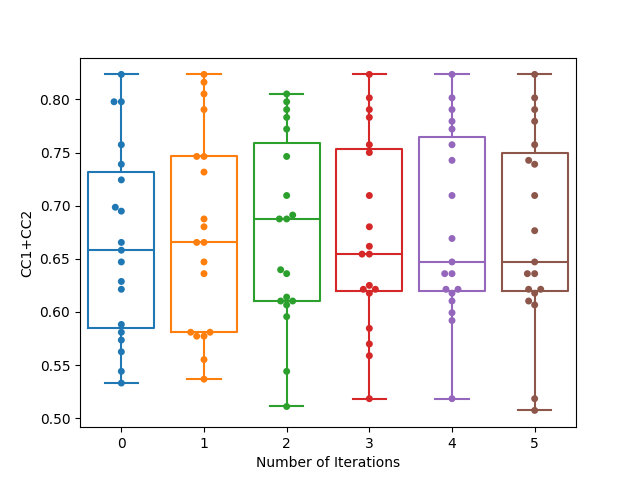

In [37]:
# plot the results as box plots, where the x-axis is the number of iterations
plt.figure()
sns.boxplot(data=acc, fill=None)
sns.swarmplot(data=acc)
plt.xlabel('Number of Iterations')
plt.ylabel('CC1+CC2')
plt.show()


In [ ]:
acc

In [23]:
# track_resolu = 10
# MAX_ITER = 6
label_resolu = 20
coe = 0.5
MAX_ITER = 5
track_resolu = 30
pair_ids = []
rt = np.zeros((nb_subj, MAX_ITER))
corr_sum = np.zeros((nb_subj, MAX_ITER))
acc = np.zeros((nb_subj, MAX_ITER))
w_data = np.zeros((nb_subj, 64*L_data, 5))
w_feats = np.zeros((nb_subj, L_feats, 5)) 
for Subj_ID in range(nb_subj):
    file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_trackresolu{track_resolu}_labelchanged_{''.join(map(str, pair_ids))}_coe{coe}_nbiter{MAX_ITER}{'_lwcov' if LWCOV else ''}.pkl'
    with open(file_name, 'rb') as f:
        res = pickle.load(f)
        rt[Subj_ID,:] = res['rt_list']
        corr_sum[Subj_ID,:] = res['corr_sum_list']
        acc[Subj_ID,:] = res['acc_list']

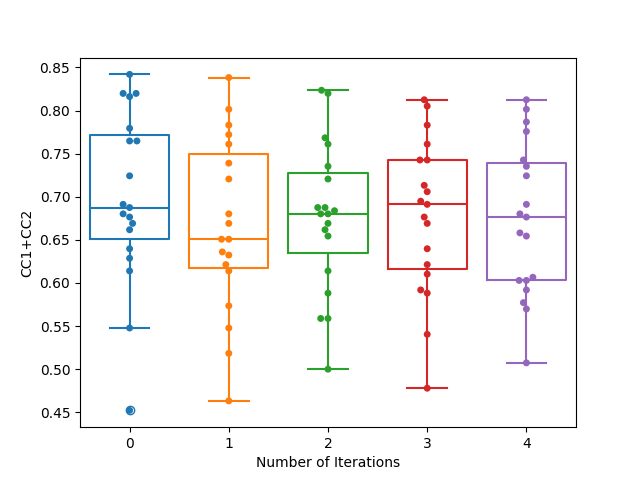

In [24]:
# plot the results as box plots, where the x-axis is the number of iterations
plt.figure()
sns.boxplot(data=acc, fill=None)
sns.swarmplot(data=acc)
plt.xlabel('Number of Iterations')
plt.ylabel('CC1+CC2')
plt.show()


In [72]:
# Check subject 1, 4, 6, 7, 8, 11
Subj_ID = 'Pseudo'
# Subj_ID = 0
TRUELABEL = True
track_resolu = 10
file_name = f'{table_path}{Subj_ID}_{TRAIN_MODE}_{'crossview' if CROSSVIEW else 'featview'}_resolu{track_resolu}_{'truelabel' if TRUELABEL else 'falselabel'}.pkl'
with open(file_name, 'rb') as f:
    res = pickle.load(f)
    model = res['model']
    influence_list = res['influence_list']
    avg_mag_list = res['avg_mag_list']
    rt_list = res['rt_list']
    corr_sum_list = res['corr_sum_list']

In [ ]:
mask_list = [influence[0,...] > influence[1,...] for influence in influence_list]
mask_arr = np.array(mask_list)
plt.close('all')
# create 5 subplots
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
# flatten the axes into a 1D array
axes = axes.flatten()
for i, ax in enumerate(axes):
    # sns.heatmap(np.expand_dims(mask_arr[i,:], axis=0), cmap='Greys', cbar=True, ax=ax, alpha=0.3)
    # ax.plot(avg_mag_list[i].T)  # Plot the line on the twin Axes
    # ax.plot(influence_list[i].T)
    ax.plot((avg_mag_list[i][0,:]-avg_mag_list[i][1,:])/np.mean(avg_mag_list[i]), 'k--')
    # add a vertical line if the mask is False
    for j, mask in enumerate(mask_list[i]):
        if not mask:
            ax.axvline(j, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [80]:
# bit wise and for mask_list[1], mask_list[2], mask_list[3], mask_list[4]
mask_noise = copy.deepcopy(mask_list[1])
for mask in mask_list[2:]:
    mask_noise = np.bitwise_and(mask_noise, mask)
mask_att = copy.deepcopy(mask_list[0])
for i in range(len(mask_list[0])):
    if not mask_noise[i] and not mask_list[0][i]:
        mask_att[i] = True


In [81]:
mask_ext = [[mask]*fs*track_resolu for mask in mask_att]
# flatten the list
mask_ext = [item for sublist in mask_ext for item in sublist]

In [82]:
idx_list = [range(fs, fs+data.shape[0]) for data in modal_dict['EEG']][2:]
len_list = [data.shape[0] for data in modal_dict['EEG']][2:]
# additive sum of the lengths of the EEG data
len_cum_list = np.cumsum(len_list)


In [83]:
mask_ext = mask_ext + [True]*(len_cum_list[-1]-len(mask_ext)) # not necessarily true
# divide the mask into segments based on len_cum_list
mask_seg_list = [mask_ext[start:end] for start, end in zip([0]+len_cum_list[:-1].tolist(), len_cum_list.tolist())]

In [84]:
idx_identified = [np.array(idx_list[i])[[not mask for mask in mask_seg_list[i]]] for i in range(len(mask_seg_list))]

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
for i, idx in enumerate(idx_identified):
    ax.plot(idx/fs, (i+1)*np.ones_like(idx), 'o')
plt.show()

In [ ]:
mask = mask_att
avg_mag = avg_mag_list[0]
avg_mag_diff = avg_mag[0, :] - avg_mag[1, :]
mag_group_0 = [avg_mag_diff[i]/np.mean(avg_mag_diff) for i, mask in enumerate(mask) if mask]
mag_group_1 = [avg_mag_diff[i]/np.mean(avg_mag_diff) for i, mask in enumerate(mask) if not mask]
# polt the box plots of the two groups, use sns
plt.close('all')
fig, ax = plt.subplots()
sns.boxplot(data=[mag_group_0, mag_group_1], ax=ax)
# change x tick labels
ax.set_xticklabels(['influ_att>influ_unatt', 'influ_att<influ_unatt'])
# sns.swarmplot(data=[mag_group_0, mag_group_1], color=".25", ax=ax)
ax.set_ylabel('mag_att-mag_unatt')
plt.show()


In [ ]:
mask_list = [influence[0,...] > influence[1,...] for influence in influence_list]
mask_arr = np.array(mask_list)
# plot mask_arr as a heatmap
plt.figure()
sns.heatmap(mask_arr, cmap='coolwarm', cbar=True)
# Put the values in corr_sum_list along the y-axis, keep 4 decimal places
# Put the ticks in the middle of the cells
plt.yticks(ticks=np.arange(len(corr_sum_list)), labels=[f'{corr:.4f}' for corr in corr_sum_list])
plt.show()

In [ ]:
# # load the results
# file_tl = f'{table_path}rt_corr_{'crossview' if CROSSVIEW else 'featview'}_resolu{track_resolu}_truelabel.pkl'
# file_fl = f'{table_path}rt_corr_{'crossview' if CROSSVIEW else 'featview'}_resolu{track_resolu}_falselabel.pkl'
# with open(file_tl, 'rb') as f:
#     res = pickle.load(f)
#     rt_allsubj_tl = res['rt_allsubj']
#     corr_sum_allsubj_tl = res['corr_sum_allsubj']
# with open(file_fl, 'rb') as f:
#     res = pickle.load(f)
#     rt_allsubj_fl = res['rt_allsubj']
#     corr_sum_allsubj_fl = res['corr_sum_allsubj']

In [ ]:
# # plot the first and second columns of corr_sum_allsubj as box plots overlaid with swarm plots
# fig, ax = plt.subplots()
# data = np.concatenate((rt_allsubj_fl[:, :5], rt_allsubj_tl[:, :5]), axis=1)
# df = pd.DataFrame(data, columns=['ModLabel_Iter1', 'ModLabel_Iter2', 'ModLabel_Iter3', 'ModLabel_Iter4', 'ModLabel_Iter5', 'OriLabel_Iter1', 'OriLabel_Iter2', 'OriLabel_Iter3', 'OriLabel_Iter4', 'OriLabel_Iter5'])
# df_melt = df.melt(var_name='Iteration', value_name='Correlation Sum')
# sns.boxplot(x='Iteration', y='Correlation Sum', data=df_melt, ax=ax, color='white')
# sns.swarmplot(x='Iteration', y='Correlation Sum', data=df_melt, ax=ax)
# ax.set_ylabel('RT')
# ax.set_xlabel('')
# plt.show()

In [ ]:
# # plot the first and second columns of corr_sum_allsubj as box plots overlaid with swarm plots
# fig, ax = plt.subplots()
# data = np.concatenate((corr_sum_allsubj_fl[:, :5], corr_sum_allsubj_tl[:, :5]), axis=1)
# df = pd.DataFrame(data, columns=['ModLabel_Iter1', 'ModLabel_Iter2', 'ModLabel_Iter3', 'ModLabel_Iter4', 'ModLabel_Iter5', 'OriLabel_Iter1', 'OriLabel_Iter2', 'OriLabel_Iter3', 'OriLabel_Iter4', 'OriLabel_Iter5'])
# df_melt = df.melt(var_name='Iteration', value_name='Correlation Sum')
# sns.boxplot(x='Iteration', y='Correlation Sum', data=df_melt, ax=ax, color='white')
# sns.swarmplot(x='Iteration', y='Correlation Sum', data=df_melt, ax=ax)
# ax.set_ylabel('CC1+CC2')
# ax.set_xlabel('')
# plt.show()


In [ ]:
# fs = 30
# method = 'CorrCA'
# LWCOV = True
# MOD = 'EEG-EOG'
# views_list = [[data[:,:,n] for data in modal_dict[MOD]] for n in range(nb_subj)]
# views_aug_list = [[data[:,:,n] for data in modal_dict_SO[MOD]] for n in range(nb_subj)]
# L_data = 5
# offset_data = (L_data-1)//2
# params_hankel = [(L_data, offset_data)] * nb_subj
# CONTAIN_PARTIALS = False
# VALSET = True
# # table_path = f'tables/{MOD}/'
# # utils.create_dir(table_path, CLEAR=False)


# influ = {}
# MCCA = algo_ccazoo.MultiViewCorrelationAnalysis(views_list, method, fs, params_hankel, CONTAIN_PARTIALS, views_aug_list=views_aug_list, n_components=7, VALSET=VALSET)
# if not LWCOV:
#     param_grid = {
#         'c': list(np.logspace(-8, -3, 6)),
#     }
#     search_para_linear = 'c'
#     best_params_linear = MCCA.hyperparam_search_ivc(param_grid=param_grid)
#     print('Searched hyperparameters:', best_params_linear)
# else:
#     search_para_linear = 'N/A'
#     best_params_linear = MCCA.hyperparam_search_ivc(param_grid=None)
#     print('No hyperparameters to search')
# ivc_train_fold, ivc_test_fold, sig_ivc, model_fold = MCCA.inter_view_corr(SIGNIFI_LEVEL=False)
# res_linear = {'ivc_train': np.average(ivc_train_fold, axis=0), 'ivc_test': np.average(ivc_test_fold, axis=0), 'sig_ivc': sig_ivc}


In [ ]:
# fs = 30
# method = 'MCCA'
# LWCOV = True
# MOD = 'EEG-EOG'
# views_list = [[data[:,:,n] for data in modal_dict[MOD]] for n in range(nb_subj)]
# views_aug_list = [[data[:,:,n] for data in modal_dict_SO[MOD]] for n in range(nb_subj)]
# L_data = 5
# offset_data = (L_data-1)//2
# params_hankel = [(L_data, offset_data)] * nb_subj
# CONTAIN_PARTIALS = False
# VALSET = True
# # table_path = f'tables/{MOD}/'
# # utils.create_dir(table_path, CLEAR=False)


# influ = {}
# MCCA = algo_ccazoo.MultiViewCorrelationAnalysis(views_list, method, fs, params_hankel, CONTAIN_PARTIALS, views_aug_list=views_aug_list, n_components=7, VALSET=VALSET)
# if not LWCOV:
#     param_grid = {
#         'c': list(np.logspace(-8, -3, 6)),
#     }
#     search_para_linear = 'c'
#     best_params_linear = MCCA.hyperparam_search_ivc(param_grid=param_grid)
#     print('Searched hyperparameters:', best_params_linear)
# else:
#     search_para_linear = 'N/A'
#     # best_params_linear = MCCA.hyperparam_search_ivc(param_grid=None)
#     print('No hyperparameters to search')
# ivc_train_fold, ivc_test_fold, sig_ivc, model_fold = MCCA.inter_view_corr(SIGNIFI_LEVEL=False)
# res_linear = {'ivc_train': np.average(ivc_train_fold, axis=0), 'ivc_test': np.average(ivc_test_fold, axis=0), 'sig_ivc': sig_ivc}
